# Análise de Expressão Diferencial de Transcriptoma

Este notebook realiza uma análise completa de expressão gênica diferencial entre duas condições experimentais (CMC vs CMT) a partir de dados de RNA-seq. A análise inclui pré-processamento dos dados, controle de qualidade, análise exploratória, identificação de genes diferencialmente expressos e visualização dos resultados.

Os dados representam contagens de genes obtidas através de sequenciamento de RNA (RNA-seq), onde:

· CMC: Condição de controle (ex: células não tratadas)
· CMT: Condição experimental (ex: células tratadas)

A análise identifica genes que apresentam expressão significativamente diferente entre estas duas condições, o que pode revelar insights sobre mecanismos biológicos, vias de sinalização alteradas e potenciais alvos terapêuticos.

## Método

A análise segue um pipeline robusto:

1. Pré-processamento: Filtragem de genes com baixa expressão
2. Controle de Qualidade: Análise de componentes principais (PCA)
3. Análise Diferencial: Método DESeq2 para identificar genes diferencialmente expressos
4. Visualização: Heatmaps, volcano plots e outras visualizações
5. Interpretação: Análise biológica dos resultados

# Dados

Arquivo: salmon.merged.gene_counts_length_scaled.tsv, obtida pela pipeline nf-core/rnaseq -v 3.20.0, com dados cedidos pela Dr Larrisa ( bote o resto do nome dela)

· Formato: TSV (Tab-Separated Values)
· Colunas: gene_id, gene_name + amostras (CMC1, CMC2, CMT1, CMT2, etc.)
· Contagens: Normalizadas por comprimento do gene

## Objetivos

1. Identificar genes diferencialmente expressos entre CMC e CMT
2. Visualizar padrões de expressão gênica
3. Fornecer insights sobre respostas transcricionais
4. Gerar resultados para validação experimental

## Dependências

Este notebook utiliza pacotes especializados de Bioinformática em R:

· DESeq2: Análise diferencial de RNA-seq
· ggplot2: Visualização de dados
· pheatmap: Heatmaps para expressão gênica
· ggrepel: Labels não sobrepostos em gráficos







```
Autor - Carlos Daniel Moreira Duarte
Orientador - Georgios J Papas Junior
```



 Instalação de pacotes

In [ ]:
# Instalar pacotes do CRAN
install.packages(c("ggplot2", "pheatmap", "dplyr", "tidyr", "ggrepel"))


if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

# Instalar pacotes do Bioconductor
BiocManager::install(c("DESeq2", "edgeR"))


Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.21 (BiocManager 1.30.26), R 4.5.1 (2025-06-13)

Installing package(s) 'DESeq2', 'edgeR'

also installing the dependencies ‘UCSC.utils’, ‘SparseArray’, ‘GenomeInfoDb’, ‘XVector’, ‘S4Arrays’, ‘DelayedArray’, ‘futile.logger’, ‘IRanges’, ‘GenomicRanges’, ‘SummarizedExperiment’, ‘BiocParallel’


Old packages: 'boot', 'evaluate', 'later', 'Matrix', 'ragg', 'rvest',
  'textshaping', 'usethis'



Carregar bibliotecas

In [ ]:

library(DESeq2)
library(ggplot2)
library(pheatmap)
library(ggrepel)
library(dplyr)
library(tidyr)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: generics


Attaching package: ‘generics’


The following objects are masked from ‘package:base’:

    as.difftime, as.factor, as.ordered, intersect, is.element, setdiff,
    setequal, union



Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, saveRDS, table, tapply, unique,
    unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The follo

Importar dados

In [ ]:

data <- read.delim("salmon.merged.gene_counts_length_scaled.tsv",
                   sep = "\t",
                   header = TRUE,
                   check.names = FALSE)  # Importante: manter nomes das colunas originais



Pré-processamento

In [ ]:
# 2. Pré-processamento
# Remover genes com contagem zero em todas as amostras
data <- data[rowSums(data[, 3:ncol(data)]) > 0, ]

# Separar metadados e expressão
counts <- data[, 3:ncol(data)]
rownames(counts) <- data$gene_id

# Criar metadata corretamente
metadata <- data.frame(
  sample = colnames(counts),
  condition = ifelse(grepl("CMC", colnames(counts)), "CMC", "CMT"),
  row.names = colnames(counts)  # IMPORTANTE: definir row.names
)

Análise PCA

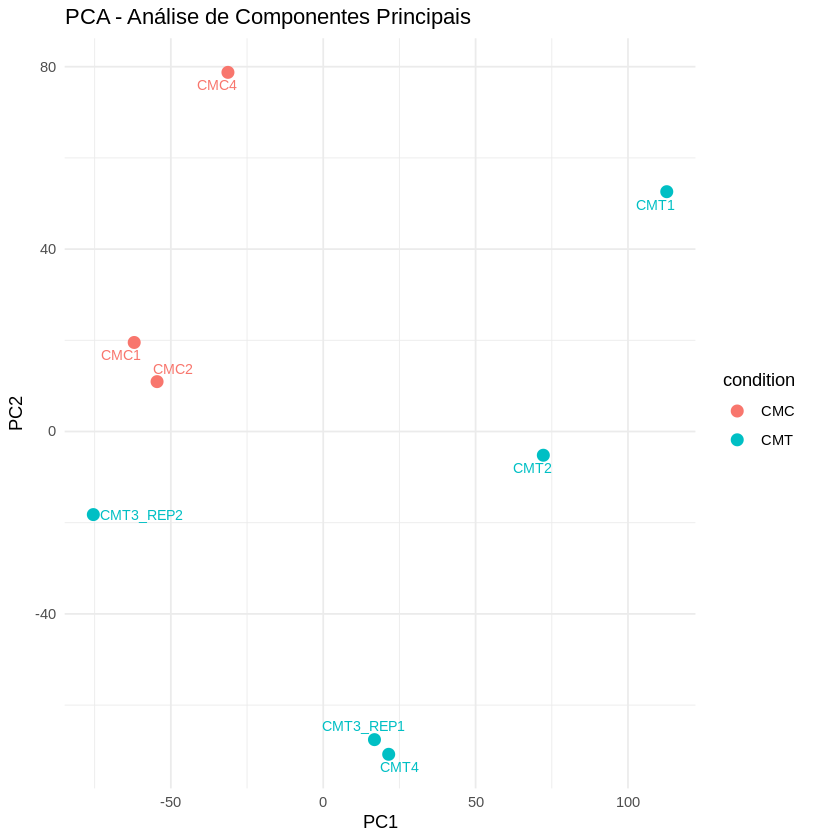

In [ ]:

pca <- prcomp(t(counts), scale. = TRUE)
pca_df <- as.data.frame(pca$x)
pca_df$condition <- ifelse(grepl("CMC", rownames(pca_df)), "CMC", "CMT")

ggplot(pca_df, aes(PC1, PC2, color = condition)) +
  geom_point(size = 3) +
  geom_text_repel(aes(label = rownames(pca_df)), size = 3) +
  theme_minimal() +
  labs(title = "PCA - Análise de Componentes Principais")


 Análise diferencial (DESeq2)

In [ ]:
# Converter metadata$condition para fator
metadata$condition <- as.factor(metadata$condition)

dds <- DESeqDataSetFromMatrix(
  countData = round(counts),  # DESeq2 espera contagens inteiras
  colData = metadata,
  design = ~ condition
)

dds <- DESeq(dds)
res <- results(dds, contrast = c("condition", "CMT", "CMC"))

# Resultados significativos (FDR < 0.05 e |log2FC| > 1)
sig_genes <- subset(res, padj < 0.05 & abs(log2FoldChange) > 1)
sig_genes <- sig_genes[order(sig_genes$padj), ]


converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



# Resultados

Heatmap

$condition
   CMC    CMT 
"blue"  "red" 



Warning message in `[.data.frame`(metadata, "condition", drop = FALSE):
“'drop' argument will be ignored”


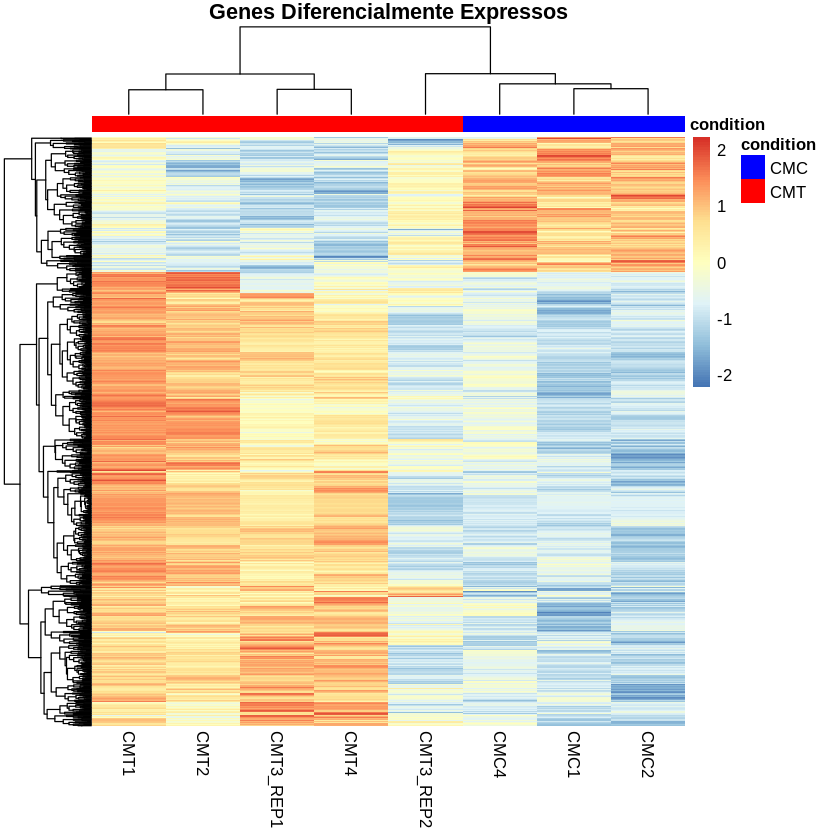

In [ ]:

# 5. Visualização
# Heatmap dos genes significativos (apenas se houver genes significativos)
if (nrow(sig_genes) > 0) {
  sig_counts <- counts[rownames(sig_genes), ]

  # Definir cores para as anotações CORRETAMENTE
  annotation_colors <- list(
    condition = c(CMC = "blue", CMT = "red")
  )

  # Verificar se as cores estão sendo aplicadas corretamente
  print(annotation_colors)

  pheatmap(
    log2(sig_counts + 1),
    annotation_col = metadata["condition", drop = FALSE],
    annotation_colors = annotation_colors,
    show_rownames = FALSE,
    scale = "row",
    main = "Genes Diferencialmente Expressos"
  )
} else {
  message("Nenhum gene significativo encontrado para o heatmap.")
}

Volcano Plot

Warning message:
“Removed 444 rows containing missing values or values outside the scale range
(`geom_point()`).”


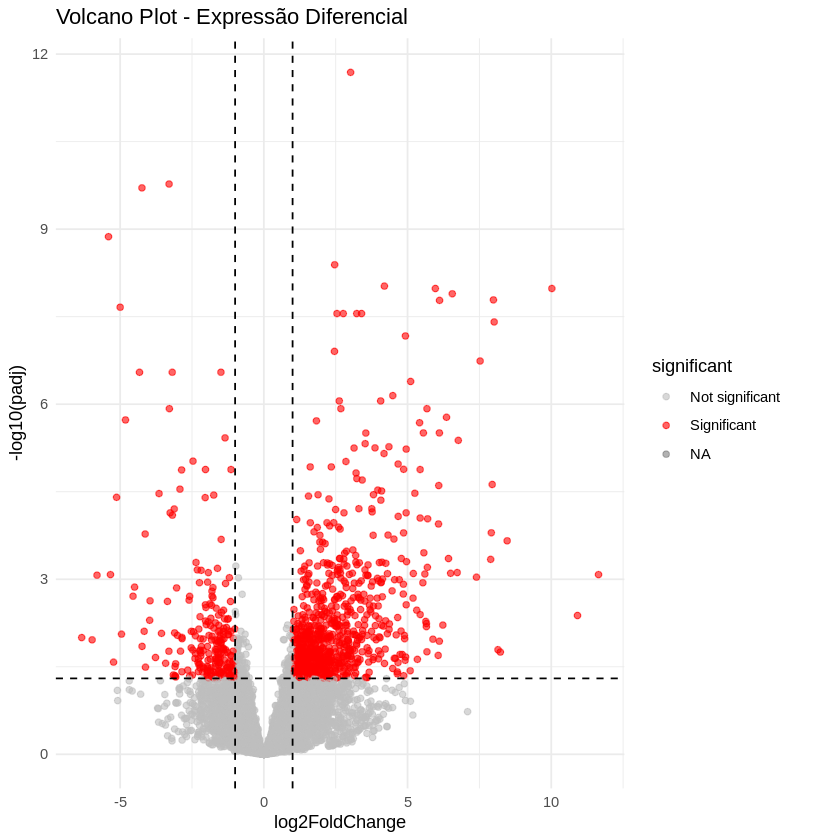

In [ ]:

volcano_df <- as.data.frame(res)
volcano_df$gene <- rownames(res)
volcano_df$significant <- ifelse(
  volcano_df$padj < 0.05 & abs(volcano_df$log2FoldChange) > 1,
  "Significant", "Not significant"
)

ggplot(volcano_df, aes(log2FoldChange, -log10(padj), color = significant)) +
  geom_point(alpha = 0.6) +
  scale_color_manual(values = c("gray", "red")) +
  theme_minimal() +
  geom_hline(yintercept = -log10(0.05), linetype = "dashed") +
  geom_vline(xintercept = c(-1, 1), linetype = "dashed") +
  labs(title = "Volcano Plot - Expressão Diferencial")

Anotação de genes significativos e salvar resultados

In [ ]:

# 6. Anotação e separação de genes significativos
if (nrow(sig_genes) > 0) {

  # Combina com os nomes dos genes
  sig_annotated <- merge(
    as.data.frame(sig_genes),
    data[, c("gene_id", "gene_name")],
    by.x = "row.names",
    by.y = "gene_id"
  )

  # Filtra genes upregulated (lfc > 2) e ordena pelo maior lfc
  up_genes <- sig_annotated %>%
    filter(log2FoldChange > 2) %>%
    arrange(desc(log2FoldChange)) %>%
    head(15)

  # Filtra genes downregulated (lfc < 0) e ordena pelo menor lfc (mais negativo)
  down_genes <- sig_annotated %>%
    filter(log2FoldChange < 0) %>%
    arrange(log2FoldChange) %>%
    head(15)

  # Salva resultados separados
  write.csv(up_genes, "upregulated_genes.csv", row.names = FALSE)
  write.csv(down_genes, "downregulated_genes.csv", row.names = FALSE)

  message("Tabelas salvas em 'upregulated_genes.csv' e 'downregulated_genes.csv'")

} else {
  message("Nenhum gene significativo encontrado.")
}


Tabelas salvas em 'upregulated_genes.csv' e 'downregulated_genes.csv'

